<b>Resampling and Frequency Conversion</b>

Resampling refers to the process of converting a time series from one frequency to
another. Aggregating higher frequency data to lower frequency is called downsampling,
while converting lower frequency to higher frequency is called upsampling. Not
all resampling falls into either of these categories; for example, converting W-WED
(weekly on Wednesday) to W-FRI is neither upsampling nor downsampling.
pandas objects are equipped with a resample method, which is the workhorse function
for all frequency conversion. resample has a similar API to groupby; you call
resample to group the data, then call an aggregation function:

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
rng = pd.date_range('2000-01-01', periods=100, freq='D')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2000-01-01    0.151425
2000-01-02    0.601692
2000-01-03   -0.426846
2000-01-04   -0.081872
2000-01-05    0.667008
                ...   
2000-04-05    0.505305
2000-04-06   -0.527875
2000-04-07    0.052973
2000-04-08   -0.283434
2000-04-09    1.389919
Freq: D, Length: 100, dtype: float64

In [6]:
ts.resample('M').mean()

2000-01-31    0.032304
2000-02-29    0.152291
2000-03-31   -0.132232
2000-04-30    0.067233
Freq: M, dtype: float64

In [7]:
ts.resample('M', kind='period').mean()

2000-01    0.032304
2000-02    0.152291
2000-03   -0.132232
2000-04    0.067233
Freq: M, dtype: float64

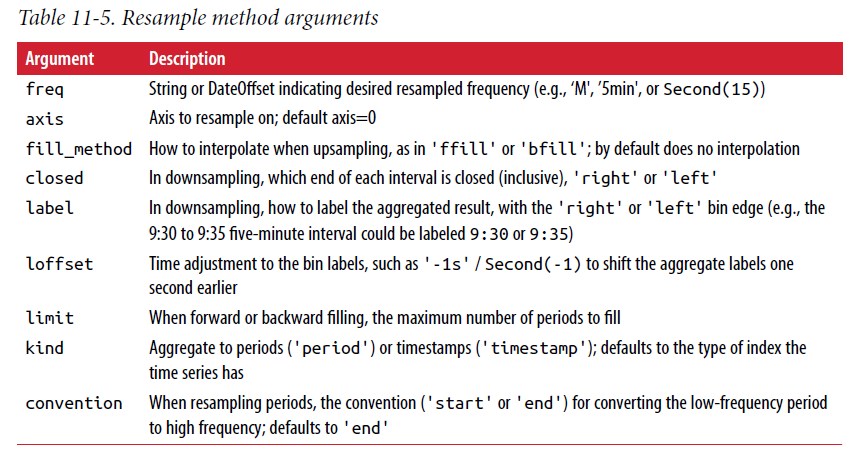

<b>Downsampling</b>

Aggregating data to a regular, lower frequency is a pretty normal time series task. The
data you’re aggregating doesn’t need to be fixed frequently; the desired frequency
defines bin edges that are used to slice the time series into pieces to aggregate. For
example, to convert to monthly, 'M' or 'BM', you need to chop up the data into onemonth
intervals. Each interval is said to be half-open; a data point can only belong to
one interval, and the union of the intervals must make up the whole time frame.

There are a couple things to think about when using resample to downsample data:

• Which side of each interval is closed

    The frequency you pass defines bin edges in five-minute increments. By default,
    the left bin edge is inclusive, so the 00:00 value is included in the 00:00 to 00:05
    interval.1 Passing closed='right' changes the interval to be closed on the right.

• How to label each aggregated bin, either with the start of the interval or the end
    
    The resulting time series is labeled by the timestamps from the left side of each bin.
    By passing label='right' you can label them with the right bin edge.

To illustrate, let’s look at some one-minute data:

In [18]:
rng = pd.date_range('2000-01-01', periods=12, freq='T')
ts = pd.Series(np.arange(12), index=rng)

In [19]:
ts

2000-01-01 00:00:00     0
2000-01-01 00:01:00     1
2000-01-01 00:02:00     2
2000-01-01 00:03:00     3
2000-01-01 00:04:00     4
2000-01-01 00:05:00     5
2000-01-01 00:06:00     6
2000-01-01 00:07:00     7
2000-01-01 00:08:00     8
2000-01-01 00:09:00     9
2000-01-01 00:10:00    10
2000-01-01 00:11:00    11
Freq: T, dtype: int32

In [20]:
ts.resample('5min', closed='right').sum()

1999-12-31 23:55:00     0
2000-01-01 00:00:00    15
2000-01-01 00:05:00    40
2000-01-01 00:10:00    11
Freq: 5T, dtype: int32

In [21]:
ts.resample('5min', closed='right', label='right').sum()

2000-01-01 00:00:00     0
2000-01-01 00:05:00    15
2000-01-01 00:10:00    40
2000-01-01 00:15:00    11
Freq: 5T, dtype: int32

Lastly, you might want to shift the result index by some amount, say subtracting one
second from the right edge to make it more clear which interval the timestamp refers
to. To do this use to_offset

In [22]:
from pandas.tseries.frequencies import to_offset
ts = ts.resample('5min', closed='right',label='right').sum()
print(ts)
ts.index = ts.index + to_offset("8H")

2000-01-01 00:00:00     0
2000-01-01 00:05:00    15
2000-01-01 00:10:00    40
2000-01-01 00:15:00    11
Freq: 5T, dtype: int32


In [23]:
ts

2000-01-01 08:00:00     0
2000-01-01 08:05:00    15
2000-01-01 08:10:00    40
2000-01-01 08:15:00    11
Freq: 5T, dtype: int32

Open-High-Low-Close (OHLC) resampling
In finance, a popular way to aggregate a time series is to compute four values for each
bucket: the first (open), last (close), maximum (high), and minimal (low) values. By
using the ohlc aggregate function you will obtain a DataFrame having columns containing
these four aggregates, which are efficiently computed in a single sweep of the
data:

In [24]:
ts.resample('5min').ohlc()

,open,high,low,close
2000-01-01 08:00:00,0,0,0,0
2000-01-01 08:05:00,15,15,15,15
2000-01-01 08:10:00,40,40,40,40
2000-01-01 08:15:00,11,11,11,11


<b>Upsampling and Interpolation

When converting from a low frequency to a higher frequency, no aggregation is
needed.

In [29]:
frame = pd.DataFrame(np.random.randn(2, 4),index=pd.date_range('1/1/2000', periods=2,freq='W-WED'),
                     columns=['Colorado', 'Texas', 'New York', 'Ohio'])

In [30]:
frame

,Colorado,Texas,New York,Ohio
2000-01-05,-1.819064,2.202315,0.715310,0.341701
2000-01-12,-0.262419,-0.962435,-0.673901,0.314079


In [33]:
df_daily = frame.resample('D').asfreq()

In [34]:
df_daily

,Colorado,Texas,New York,Ohio
2000-01-05,-1.819064,2.202315,0.715310,0.341701
2000-01-06,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,-0.262419,-0.962435,-0.673901,0.314079


Suppose you wanted to fill forward each weekly value on the non-Wednesdays. The
same filling or interpolation methods available in the fillna and reindex methods
are available for resampling

In [35]:
frame.resample('D').ffill()

,Colorado,Texas,New York,Ohio
2000-01-05,-1.819064,2.202315,0.715310,0.341701
2000-01-06,-1.819064,2.202315,0.715310,0.341701
2000-01-07,-1.819064,2.202315,0.715310,0.341701
2000-01-08,-1.819064,2.202315,0.715310,0.341701
2000-01-09,-1.819064,2.202315,0.715310,0.341701
2000-01-10,-1.819064,2.202315,0.715310,0.341701
2000-01-11,-1.819064,2.202315,0.715310,0.341701
2000-01-12,-0.262419,-0.962435,-0.673901,0.314079


<b>Resampling with Periods

Resampling data indexed by periods is similar to timestamps:

Upsampling is more nuanced, as you must make a decision about which end of the
timespan in the new frequency to place the values before resampling, just like the
asfreq method. The convention argument defaults to 'start' but can also be 'end':

In [36]:
frame = pd.DataFrame(np.random.randn(24, 4),index=pd.period_range('1-2000', '12-2001',freq='M'),
                     columns=['Colorado', 'Texas', 'New York', 'Ohio'])

In [37]:
annual_frame = frame.resample('A-DEC').mean()

In [38]:
annual_frame.resample('Q-DEC').ffill()

,Colorado,Texas,New York,Ohio
2000Q1,-0.127602,0.379284,0.388343,-0.077902
2000Q2,-0.127602,0.379284,0.388343,-0.077902
2000Q3,-0.127602,0.379284,0.388343,-0.077902
2000Q4,-0.127602,0.379284,0.388343,-0.077902
2001Q1,-0.208238,0.033243,0.025045,-0.272275
2001Q2,-0.208238,0.033243,0.025045,-0.272275
2001Q3,-0.208238,0.033243,0.025045,-0.272275
2001Q4,-0.208238,0.033243,0.025045,-0.272275


In [39]:
annual_frame.resample('Q-DEC', convention='end').ffill()

,Colorado,Texas,New York,Ohio
2000Q4,-0.127602,0.379284,0.388343,-0.077902
2001Q1,-0.127602,0.379284,0.388343,-0.077902
2001Q2,-0.127602,0.379284,0.388343,-0.077902
2001Q3,-0.127602,0.379284,0.388343,-0.077902
2001Q4,-0.208238,0.033243,0.025045,-0.272275


Since periods refer to timespans, the rules about upsampling and downsampling are
more rigid:

• In downsampling, the target frequency must be a subperiod of the source
frequency.

• In upsampling, the target frequency must be a superperiod of the source
frequency

<b>Moving Window Functions

An important class of array transformations used for time series operations are statistics
and other functions evaluated over a sliding window or with exponentially decaying
weights. This can be useful for smoothing noisy or gappy data

Like other statistical functions, these
also automatically exclude missing data.
Before digging in, we can load up some time series data and resample it to business
day frequency:

In [43]:
close_px_all = pd.read_csv('D:\Datasets\stock_px_2.csv',parse_dates=True, index_col=0)

In [44]:
close_px_all

,AAPL,MSFT,XOM,SPX
2003-01-02,7.40,21.11,29.22,909.03
2003-01-03,7.45,21.14,29.24,908.59
2003-01-06,7.45,21.52,29.96,929.01
2003-01-07,7.43,21.93,28.95,922.93
2003-01-08,7.28,21.31,28.83,909.93
...,...,...,...,...
2011-10-10,388.81,26.94,76.28,1194.89
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66


In [46]:
close_px = close_px_all[['AAPL', 'MSFT', 'XOM']]
close_px = close_px.resample('B').ffill()
close_px

,AAPL,MSFT,XOM
2003-01-02,7.40,21.11,29.22
2003-01-03,7.45,21.14,29.24
2003-01-06,7.45,21.52,29.96
2003-01-07,7.43,21.93,28.95
2003-01-08,7.28,21.31,28.83
...,...,...,...
2011-10-10,388.81,26.94,76.28
2011-10-11,400.29,27.00,76.27
2011-10-12,402.19,26.96,77.16
2011-10-13,408.43,27.18,76.37


Now introduce the rolling operator, which behaves similarly to resample and
groupby. It can be called on a Series or DataFrame along with a window (expressed as
a number of periods

<AxesSubplot:>

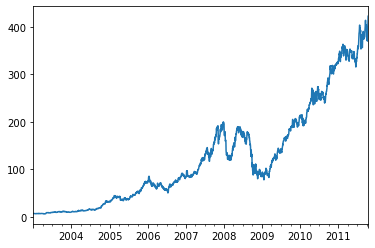

In [47]:
close_px.AAPL.plot()

<AxesSubplot:>

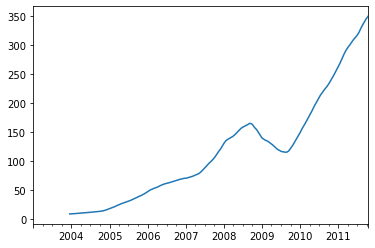

In [49]:
close_px.AAPL.rolling(250).mean().plot() #250 days MA

The expression rolling(250) is similar in behavior to groupby, but instead of grouping
it creates an object that enables grouping over a 250-day sliding window. So here
we have the 250-day moving window average of Apple’s stock price.

By default rolling functions require all of the values in the window to be non-NA.
This behavior can be changed to account for missing data and, in particular, the fact
that you will have fewer than window periods of data at the beginning of the time
series

In [50]:
appl_std250 = close_px.AAPL.rolling(250, min_periods=10).std()

In [51]:
appl_std250[5:12]

2003-01-09         NaN
2003-01-10         NaN
2003-01-13         NaN
2003-01-14         NaN
2003-01-15    0.077496
2003-01-16    0.074760
2003-01-17    0.112368
Freq: B, Name: AAPL, dtype: float64

<AxesSubplot:>

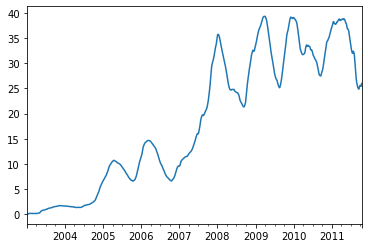

In [52]:
appl_std250.plot()

In order to compute an expanding window mean, use the expanding operator instead
of rolling. The expanding mean starts the time window from the beginning of the
time series and increases the size of the window until it encompasses the whole series.

In [53]:
expanding_mean = appl_std250.expanding().mean()

In [54]:
expanding_mean

2003-01-02          NaN
2003-01-03          NaN
2003-01-06          NaN
2003-01-07          NaN
2003-01-08          NaN
                ...    
2011-10-10    18.521201
2011-10-11    18.524272
2011-10-12    18.527385
2011-10-13    18.530554
2011-10-14    18.533823
Freq: B, Name: AAPL, Length: 2292, dtype: float64

<AxesSubplot:>

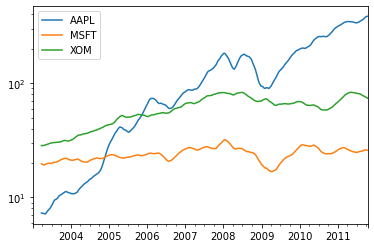

In [55]:
close_px.rolling(60).mean().plot(logy=True)

The rolling function also accepts a string indicating a fixed-size time offset rather
than a set number of periods. Using this notation can be useful for irregular time series.
These are the same strings that you can pass to resample. For example, we could
compute a 20-day rolling mean like so:

In [56]:
close_px.rolling('20D').mean()

,AAPL,MSFT,XOM
2003-01-02,7.400000,21.110000,29.220000
2003-01-03,7.425000,21.125000,29.230000
2003-01-06,7.433333,21.256667,29.473333
2003-01-07,7.432500,21.425000,29.342500
2003-01-08,7.402000,21.402000,29.240000
...,...,...,...
2011-10-10,389.351429,25.602143,72.527857
2011-10-11,388.505000,25.674286,72.835000
2011-10-12,388.531429,25.810000,73.400714
2011-10-13,388.826429,25.961429,73.905000


<b>Exponentially Weighted Functions</b>

An alternative to using a static window size with equally weighted observations is to
specify a constant decay factor to give more weight to more recent observations.
There are a couple of ways to specify the decay factor. A popular one is using a span,
which makes the result comparable to a simple moving window function with window
size equal to the span.
Since an exponentially weighted statistic places more weight on more recent observations,
it “adapts” faster to changes compared with the equal-weighted version.
pandas has the ewm operator to go along with rolling and expanding. Here’s an
example comparing a 60-day moving average of Apple’s stock price with an EW moving
average with span=60

In [65]:
aapl_px = close_px.AAPL['2006':'2007']

In [66]:
ma60 = aapl_px.rolling(30, min_periods=20).mean()
ewma60 = aapl_px.ewm(span=30).mean()

<AxesSubplot:>

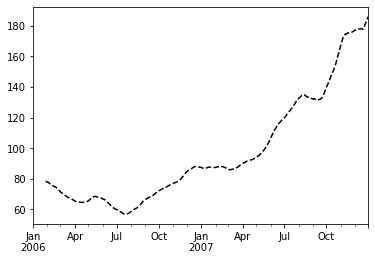

In [67]:
ma60.plot(style='k--', label='Simple MA')

<AxesSubplot:>

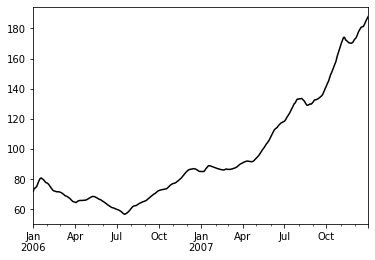

In [68]:
ewma60.plot(style='k-', label='EW MA')

<b>Binary Moving Window Functions

Some statistical operators, like correlation and covariance, need to operate on two
time series. As an example, financial analysts are often interested in a stock’s correlation
to a benchmark index like the S&P 500.

In [70]:
spx_px = close_px_all['SPX']
spx_rets = spx_px.pct_change()
returns = close_px.pct_change()

The corr aggregation function after we call rolling can then compute the rolling
correlation with spx_rets (see Figure 11-8 for the resulting plot):

<AxesSubplot:>

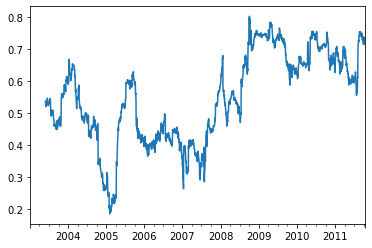

In [71]:
corr = returns.AAPL.rolling(125, min_periods=100).corr(spx_rets)
corr.plot()

Suppose you wanted to compute the correlation of the S&P 500 index with many
stocks at once. Writing a loop and creating a new DataFrame would be easy but might
get repetitive, so if you pass a Series and a DataFrame, a function like rolling_corr
will compute the correlation of the Series (spx_rets, in this case) with each column
in the DataFrame

<AxesSubplot:>

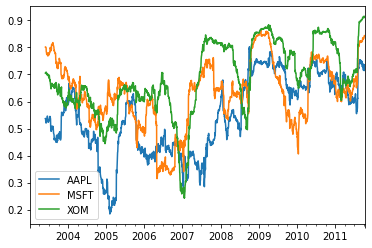

In [72]:
corr = returns.rolling(125, min_periods=100).corr(spx_rets)
corr.plot()

<b>User-Defined Moving Window Functions

The apply method on rolling and related methods provides a means to apply an
array function of your own devising over a moving window. The only requirement is
that the function produce a single value (a reduction) from each piece of the array.
For example, while we can compute sample quantiles using rolling(...).quan
tile(q), we might be interested in the percentile rank of a particular value over the
sample. The scipy.stats.percentileofscore function does just this

<AxesSubplot:>

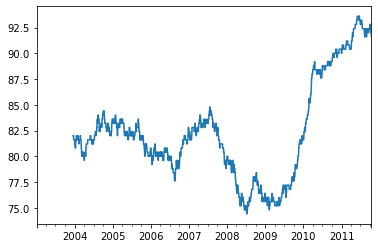

In [73]:
from scipy.stats import percentileofscore

score_at_2percent = lambda x: percentileofscore(x, 0.02)

result = returns.AAPL.rolling(250).apply(score_at_2percent)

result.plot()

Percentile rank of 2% AAPL return over one-year window